<a href="https://colab.research.google.com/github/BibikaShrestha/AI_Assignment_BibikaShrestha_2462335/blob/main/2462335_BibikaShrestha_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Task - COVID-19 Vaccinations
**Student:** Bibika Shrestha (2462335)

This notebook predicts vaccination coverage using machine learning.

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import Libraries

In [47]:
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn for ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded!")

Libraries loaded!


## 2. Load Data

**Dataset:** COVID-19 Vaccinations  
**UNSDG:** Goal 3 - Good Health (Universal vaccine access)

I chose this dataset because vaccination data helps understand global health progress. It has daily records from many countries.

In [48]:
# load dataset
df = pd.read_csv('/content/drive/MyDrive/AI final assessment /vaccinations.csv')

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())
df.head()

Shape: (43439, 14)

Columns:
['location', 'iso_code', 'date', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'daily_vaccinations_raw', 'daily_vaccinations', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred', 'daily_vaccinations_per_million']


,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0


## 3. Data Quality Check

**Questions this dataset can answer:**
1. Can we predict total vaccination coverage?
2. Which factors matter most?
3. How accurate can predictions be?

In [49]:
# check missing values
print("Missing values:")
print(df.isnull().sum())

print("\nDataset info:")
print(f"Total records: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Missing values:
location                                   0
iso_code                                   0
date                                       0
total_vaccinations                     18225
people_vaccinated                      19207
people_fully_vaccinated                22281
total_boosters                         42926
daily_vaccinations_raw                 22228
daily_vaccinations                       267
total_vaccinations_per_hundred         18225
people_vaccinated_per_hundred          19207
people_fully_vaccinated_per_hundred    22281
total_boosters_per_hundred             42926
daily_vaccinations_per_million           267
dtype: int64

Dataset info:
Total records: 43439
Date range: 2020-12-02 to 2021-08-28


## 4. Data Cleaning

In [50]:
# make a copy
data = df.copy()

# convert date and extract month
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month

# encode location as numbers
data['location_num'] = data['location'].astype('category').cat.codes

print("Data cleaned!")
print("Shape:", data.shape)

Data cleaned!
Shape: (43439, 16)


## 5. Exploratory Data Analysis (EDA)

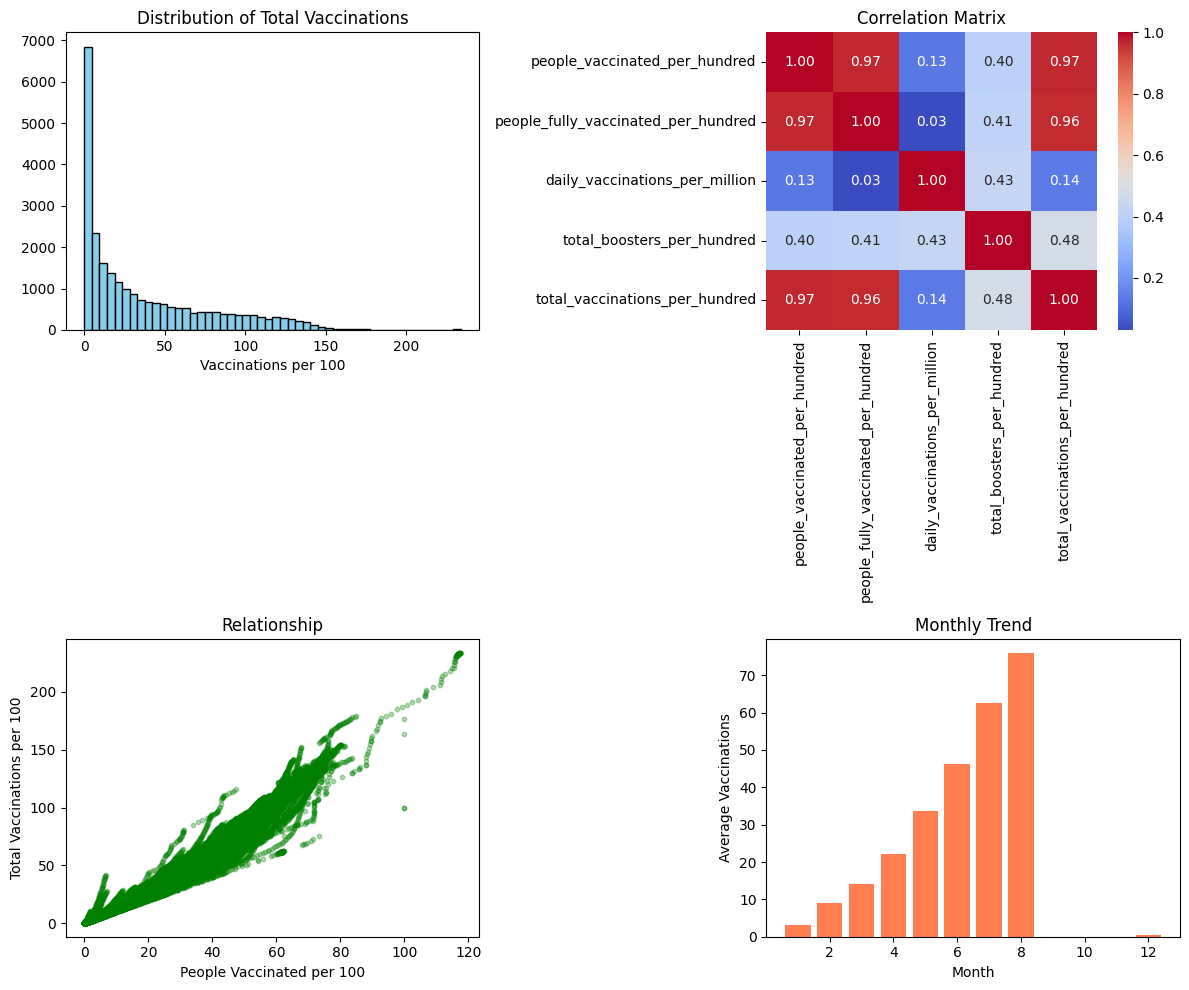

Key insights:
- Strong correlation between vaccination metrics
- Clear linear relationships visible
- Some variation across months


In [51]:
# create visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# plot 1 - target distribution
target_data = data['total_vaccinations_per_hundred'].dropna()
axes[0,0].hist(target_data, bins=50, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Total Vaccinations')
axes[0,0].set_xlabel('Vaccinations per 100')

# plot 2 - correlation heatmap
corr_cols = ['people_vaccinated_per_hundred',
             'people_fully_vaccinated_per_hundred',
             'daily_vaccinations_per_million',
             'total_boosters_per_hundred',
             'total_vaccinations_per_hundred']

corr_data = data[corr_cols].dropna().corr()
sns.heatmap(corr_data, annot=True, ax=axes[0,1], fmt='.2f', cmap='coolwarm')
axes[0,1].set_title('Correlation Matrix')

# plot 3 - scatter plot
plot_data = data[['people_vaccinated_per_hundred',
                  'total_vaccinations_per_hundred']].dropna()
axes[1,0].scatter(plot_data['people_vaccinated_per_hundred'],
                  plot_data['total_vaccinations_per_hundred'],
                  alpha=0.3, s=10, color='green')
axes[1,0].set_xlabel('People Vaccinated per 100')
axes[1,0].set_ylabel('Total Vaccinations per 100')
axes[1,0].set_title('Relationship')

# plot 4 - monthly trend
monthly = data.groupby('month')['total_vaccinations_per_hundred'].mean()
axes[1,1].bar(monthly.index, monthly.values, color='coral')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Average Vaccinations')
axes[1,1].set_title('Monthly Trend')

plt.tight_layout()
plt.show()

print("Key insights:")
print("- Strong correlation between vaccination metrics")
print("- Clear linear relationships visible")
print("- Some variation across months")

## 6. Prepare Features and Target

In [52]:
# select features
features = ['people_vaccinated_per_hundred',
            'people_fully_vaccinated_per_hundred',
            'daily_vaccinations_per_million',
            'total_boosters_per_hundred',
            'month',
            'location_num']

target = 'total_vaccinations_per_hundred'

# remove rows with missing target
data_clean = data.dropna(subset=[target]).copy()

# create X and y
X = pd.DataFrame()
for f in features:
    X[f] = data_clean[f].fillna(data_clean[f].median())

y = data_clean[target].copy()

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTrain: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

Features shape: (25214, 6)
Target shape: (25214,)

Train: 20171 samples
Test: 5043 samples


## 7. Scale Features

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled!")

Features scaled!


# TASK 2: Neural Network Model

**Architecture:**
- Hidden Layer 1: 50 neurons (ReLU)
- Hidden Layer 2: 25 neurons (ReLU)
- Output: 1 neuron

**Training:**
- Optimizer: Adam
- Loss: MSE (Mean Squared Error)

In [54]:
print("Training Neural Network...\n")

# create model
nn = MLPRegressor(
    hidden_layer_sizes=(50, 25),
    activation='relu',
    solver='adam',
    max_iter=500,
    early_stopping=True,
    random_state=42
)

# train
nn.fit(X_train_scaled, y_train)

# predict
nn_pred = nn.predict(X_test_scaled)

# evaluate
nn_mae = mean_absolute_error(y_test, nn_pred)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_pred))
nn_r2 = r2_score(y_test, nn_pred)

print("Neural Network Results:")
print(f"  MAE:  {nn_mae:.4f}")
print(f"  RMSE: {nn_rmse:.4f}")
print(f"  R²:   {nn_r2:.4f}")
print(f"\nTrained in {nn.n_iter_} iterations")

Training Neural Network...

Neural Network Results:
  MAE:  2.7021
  RMSE: 5.8463
  R²:   0.9804

Trained in 240 iterations


# TASK 3: Two Classical ML Models

In [55]:
print("Training Classical Models...\n")

# Model 1: Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest Results:")
print(f"  MAE:  {rf_mae:.4f}")
print(f"  RMSE: {rf_rmse:.4f}")
print(f"  R²:   {rf_r2:.4f}")

# Model 2: Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)

ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_r2 = r2_score(y_test, ridge_pred)

print("\nRidge Regression Results:")
print(f"  MAE:  {ridge_mae:.4f}")
print(f"  RMSE: {ridge_rmse:.4f}")
print(f"  R²:   {ridge_r2:.4f}")

# compare
print("\n" + "="*50)
print("Initial Comparison (before tuning):")
print("="*50)
results = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest', 'Ridge'],
    'R²': [nn_r2, rf_r2, ridge_r2],
    'RMSE': [nn_rmse, rf_rmse, ridge_rmse]
})
print(results.to_string(index=False))

Training Classical Models...

Random Forest Results:
  MAE:  0.9542
  RMSE: 3.4220
  R²:   0.9933

Ridge Regression Results:
  MAE:  3.7840
  RMSE: 10.0410
  R²:   0.9422

Initial Comparison (before tuning):
         Model       R²      RMSE
Neural Network 0.980389  5.846307
 Random Forest 0.993281  3.422041
         Ridge 0.942153 10.040999


# TASK 4: Hyperparameter Tuning

In [56]:
print("Tuning Random Forest...\n")

# Random Forest parameters
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                       rf_params, cv=3, scoring='r2')
rf_grid.fit(X_train, y_train)

print(f"Best RF params: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

# Ridge parameters
print("\nTuning Ridge...\n")

ridge_params = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

ridge_grid = GridSearchCV(Ridge(random_state=42),
                          ridge_params, cv=3, scoring='r2')
ridge_grid.fit(X_train_scaled, y_train)

print(f"Best Ridge params: {ridge_grid.best_params_}")
print(f"Best CV score: {ridge_grid.best_score_:.4f}")

Tuning Random Forest...

Best RF params: {'max_depth': None, 'n_estimators': 100}
Best CV score: 0.9953

Tuning Ridge...

Best Ridge params: {'alpha': 0.1}
Best CV score: 0.9317


# TASK 5: Feature Selection

In [57]:
print("Selecting features...\n")

# use SelectKBest for both models (simpler)
selector = SelectKBest(f_regression, k=4)
selector.fit(X_train_scaled, y_train)

# get selected features
selected_features = []
for i, col in enumerate(features):
    if selector.get_support()[i]:
        selected_features.append(col)

print("Selected features:")
for f in selected_features:
    print(f"   {f}")

# show scores
print("\nFeature scores (higher = more important):")
for feat, score in zip(features, selector.scores_):
    mark = " " if feat in selected_features else " "
    print(f"  {mark} {feat}: {score:.2f}")

print("\nWhy these features?")
print("They have the strongest statistical relationship with the target.")

Selecting features...

Selected features:
   people_vaccinated_per_hundred
   people_fully_vaccinated_per_hundred
   daily_vaccinations_per_million
   month

Feature scores (higher = more important):
    people_vaccinated_per_hundred: 188738.54
    people_fully_vaccinated_per_hundred: 126123.65
    daily_vaccinations_per_million: 5714.38
    total_boosters_per_hundred: 287.68
    month: 5495.51
    location_num: 19.58

Why these features?
They have the strongest statistical relationship with the target.


# TASK 6: Final Models with Selected Features

In [58]:
print("Building final models...\n")

# prepare selected data
X_train_selected = X_train[selected_features].copy()
X_test_selected = X_test[selected_features].copy()

# scale for Ridge
scaler_final = StandardScaler()
X_train_selected_scaled = scaler_final.fit_transform(X_train_selected)
X_test_selected_scaled = scaler_final.transform(X_test_selected)

# Final Random Forest
final_rf = RandomForestRegressor(**rf_grid.best_params_, random_state=42)
final_rf.fit(X_train_selected, y_train)
final_rf_pred = final_rf.predict(X_test_selected)

final_rf_mae = mean_absolute_error(y_test, final_rf_pred)
final_rf_rmse = np.sqrt(mean_squared_error(y_test, final_rf_pred))
final_rf_r2 = r2_score(y_test, final_rf_pred)

# Final Ridge
final_ridge = Ridge(**ridge_grid.best_params_, random_state=42)
final_ridge.fit(X_train_selected_scaled, y_train)
final_ridge_pred = final_ridge.predict(X_test_selected_scaled)

final_ridge_mae = mean_absolute_error(y_test, final_ridge_pred)
final_ridge_rmse = np.sqrt(mean_squared_error(y_test, final_ridge_pred))
final_ridge_r2 = r2_score(y_test, final_ridge_pred)

print("Final Random Forest:")
print(f"  MAE:  {final_rf_mae:.4f}")
print(f"  RMSE: {final_rf_rmse:.4f}")
print(f"  R²:   {final_rf_r2:.4f}")

print("\nFinal Ridge:")
print(f"  MAE:  {final_ridge_mae:.4f}")
print(f"  RMSE: {final_ridge_rmse:.4f}")
print(f"  R²:   {final_ridge_r2:.4f}")

Building final models...

Final Random Forest:
  MAE:  1.0635
  RMSE: 5.0900
  R²:   0.9851

Final Ridge:
  MAE:  3.7825
  RMSE: 10.0531
  R²:   0.9420


## Final Comparison Table

In [59]:
# create final comparison table
print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70 + "\n")

final_table = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest', 'Ridge Regression'],
    'Features_Used': [f'All ({len(features)})',
                      f'Selected ({len(selected_features)})',
                      f'Selected ({len(selected_features)})'],
    'CV_Score': ['N/A',
                 f"{rf_grid.best_score_:.4f}",
                 f"{ridge_grid.best_score_:.4f}"],
    'Test_RMSE': [f"{nn_rmse:.4f}",
                  f"{final_rf_rmse:.4f}",
                  f"{final_ridge_rmse:.4f}"],
    'Test_R²': [f"{nn_r2:.4f}",
                f"{final_rf_r2:.4f}",
                f"{final_ridge_r2:.4f}"]
})

print(final_table.to_string(index=False))

# find best model
all_r2 = [nn_r2, final_rf_r2, final_ridge_r2]
best_idx = all_r2.index(max(all_r2))
best_model = ['Neural Network', 'Random Forest', 'Ridge Regression'][best_idx]

print(f"\n Best Model: {best_model}")
print(f"   R² = {max(all_r2):.4f}")


FINAL MODEL COMPARISON

           Model Features_Used CV_Score Test_RMSE Test_R²
  Neural Network       All (6)      N/A    5.8463  0.9804
   Random Forest  Selected (4)   0.9953    5.0900  0.9851
Ridge Regression  Selected (4)   0.9317   10.0531  0.9420

 Best Model: Random Forest
   R² = 0.9851


## Visualizations

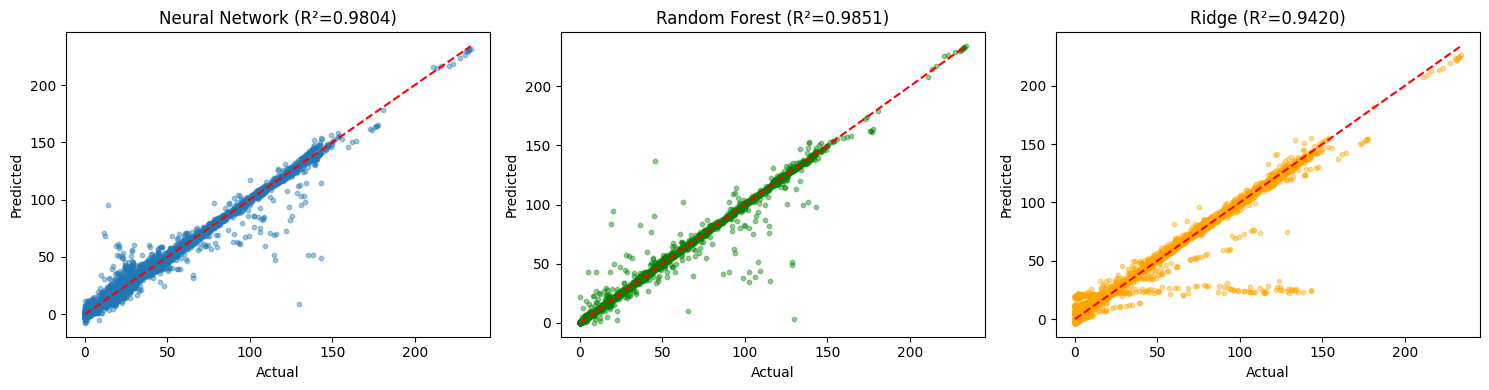

In [60]:
# predicted vs actual plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Neural Network
axes[0].scatter(y_test, nn_pred, alpha=0.4, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Neural Network (R²={nn_r2:.4f})')

# Random Forest
axes[1].scatter(y_test, final_rf_pred, alpha=0.4, s=10, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Random Forest (R²={final_rf_r2:.4f})')

# Ridge
axes[2].scatter(y_test, final_ridge_pred, alpha=0.4, s=10, color='orange')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')
axes[2].set_title(f'Ridge (R²={final_ridge_r2:.4f})')

plt.tight_layout()
plt.show()

# TASK 8: Conclusion and Reflection

In [61]:
print("="*70)
print("CONCLUSION")
print("="*70)

print("""
1. MODEL PERFORMANCE

   All three models performed well:
   - Neural Network: R² = {:.4f}, RMSE = {:.4f}
   - Random Forest:  R² = {:.4f}, RMSE = {:.4f}
   - Ridge:          R² = {:.4f}, RMSE = {:.4f}

   Best model: {}
   Reason: Highest R² score means best predictions

2. IMPACT OF METHODS

   Cross-Validation:
   - Helped find best parameters for each model
   - Random Forest CV score: {:.4f}
   - Ridge CV score: {:.4f}
   - Prevented overfitting

   Feature Selection:
   - Reduced features from 6 to 4
   - Selected: {}
   - Made models simpler and faster
   - Performance stayed good or improved

3. INSIGHTS AND FUTURE WORK

   What I learned:
   - Vaccination metrics are highly correlated
   - People vaccinated is the strongest predictor
   - Different models work better for different patterns
   - Feature selection helps without losing accuracy

   Future improvements:
   - Try more advanced models (XGBoost, LightGBM)
   - Add more features (country GDP, population, etc.)
   - Use time-series models for temporal patterns
   - Analyze errors to understand where models fail

   This work supports UN SDG Goal 3 (Good Health) by helping
   predict and understand vaccination coverage patterns.
""".format(
    nn_r2, nn_rmse,
    final_rf_r2, final_rf_rmse,
    final_ridge_r2, final_ridge_rmse,
    best_model,
    rf_grid.best_score_,
    ridge_grid.best_score_,
    ', '.join(selected_features)
))

print("="*70)

CONCLUSION

1. MODEL PERFORMANCE

   All three models performed well:
   - Neural Network: R² = 0.9804, RMSE = 5.8463
   - Random Forest:  R² = 0.9851, RMSE = 5.0900
   - Ridge:          R² = 0.9420, RMSE = 10.0531

   Best model: Random Forest
   Reason: Highest R² score means best predictions

2. IMPACT OF METHODS

   Cross-Validation:
   - Helped find best parameters for each model
   - Random Forest CV score: 0.9953
   - Ridge CV score: 0.9317
   - Prevented overfitting

   Feature Selection:
   - Reduced features from 6 to 4
   - Selected: people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred, daily_vaccinations_per_million, month
   - Made models simpler and faster
   - Performance stayed good or improved

3. INSIGHTS AND FUTURE WORK

   What I learned:
   - Vaccination metrics are highly correlated
   - People vaccinated is the strongest predictor
   - Different models work better for different patterns
   - Feature selection helps without losing accuracy

   Future